# Lab 3: Tokenization and Embeddings for Language Modeling

## 🛠️ SETUP AND INSTALLATIONS
- install the required libraries (run in notebook or terminal)
    - !pip install torch torchtext transformers matplotlib

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from collections import Counter
import numpy as np

C:\Users\aliae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##  📘 SECTION 1: What is Tokenization?
- Tokenization splits raw text into units (tokens): words, subwords, or characters.
- Tokens are then mapped to numeric IDs to be processed by models.

In [2]:
text = "I love learning about large language models."

# Example 1: Basic whitespace tokenizer
basic_tokens = text.lower().split()
print("Basic tokens:", basic_tokens)

Basic tokens: ['i', 'love', 'learning', 'about', 'large', 'language', 'models.']


In [ ]:
# Example 2: Subword tokenizer using HuggingFace
# Using a pre-trained tokenizer from HuggingFace
# This tokenizer splits text into subwords and maps them to IDs.
# bert-base-uncased is a commonly used model for English text.
# This tokenizer handles out-of-vocabulary words by breaking them into smaller subwords.
# Example: "unhappiness" might be tokenized into ["un", "happiness"].
# You can replace "bert-base-uncased" with any other model available on HuggingFace.
hf_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
hf_tokens = hf_tokenizer.tokenize(text)
hf_ids = hf_tokenizer.convert_tokens_to_ids(hf_tokens)
print("Subword tokens:", hf_tokens)
print("Token IDs:", hf_ids)

Subword tokens: ['i', 'love', 'learning', 'about', 'large', 'language', 'models', '.']
Token IDs: [1045, 2293, 4083, 2055, 2312, 2653, 4275, 1012]


## 🧱 SECTION 2: Building Vocabulary and Mapping to IDs
- A vocabulary maps each unique token to a number.
- This step is often skipped with pretrained tokenizers but important to understand.

In [5]:
# Example corpus
corpus = ["I love AI", "AI is amazing", "Transformers learn context"]

# Build vocabulary manually
all_words = " ".join(corpus).lower().split()
word_counts = Counter(all_words)
vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items())}
print("Vocabulary:", vocab)

# Map a sentence to indices
sentence = "AI is amazing"
indices = [vocab[word] for word in sentence.lower().split()]
print("Token indices:", indices)

Vocabulary: {'i': 0, 'love': 1, 'ai': 2, 'is': 3, 'amazing': 4, 'transformers': 5, 'learn': 6, 'context': 7}
Token indices: [2, 3, 4]


# 🔢 SECTION 3: Word Embeddings with nn.Embedding

- Embeddings map token IDs to dense vectors
- These vectors are learned during training

In [6]:
vocab_size = len(vocab)
embedding_dim = 5
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

word_tensor = torch.tensor(indices)  # shape: [3]
embedded = embedding_layer(word_tensor)  # shape: [3, 5]
print("Word Embeddings:\n", embedded)

Word Embeddings:
 tensor([[ 2.0764,  0.9532, -0.4930, -0.3930,  0.3854],
        [-0.2617,  1.8106,  0.5383, -0.2989,  1.5515],
        [-2.0549,  0.7954, -0.1301, -0.4799,  1.2891]],
       grad_fn=<EmbeddingBackward0>)


## 🔮 SECTION 4: Mini Language Modeling Task
- Task: Predict next word from a sequence
- Dataset: Tiny custom corpus
- Model: Simple FFNN with embedding

### Define Dataset

In [8]:
sequences = [
    ("i love", "ai"),
    ("ai is", "amazing"),
    ("transformers learn", "context")
]

### Build vocabulary 

In [ ]:

for seq, target in sequences: # This is a list of tuples where each tuple contains a sequence and its target word.
    for word in seq.split() + [target]: # We split the sequence and target word into individual words.
        if word not in vocab: # If the word is not already in the vocabulary, we add it.
            vocab[word] = len(vocab) # Assign a new index to the word.

inv_vocab = {v: k for k, v in vocab.items()} # Create an inverse vocabulary to map indices back to words.
print("Inverse Vocabulary:", inv_vocab)

Inverse Vocabulary: {0: 'i', 1: 'love', 2: 'ai', 3: 'is', 4: 'amazing', 5: 'transformers', 6: 'learn', 7: 'context'}


### Prepare training data

In [ ]:
X = []
y = []
for seq, target in sequences:
    seq_ids = [vocab[word] for word in seq.split()] # Convert sequence words to their corresponding IDs
    target_id = vocab[target] # Convert target word to its corresponding ID
    X.append(seq_ids) # Append the sequence IDs to X
    y.append(target_id) # Append the target ID to y

X_tensor = torch.tensor(X)       # Shape: (3, 2)
y_tensor = torch.tensor(y)      # Shape: (3,)

### Define Model

In [13]:
class MiniLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch, seq_len, embed_dim)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = MiniLM(vocab_size=len(vocab), embed_dim=8, hidden_dim=16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Train Model

Epoch 10, Loss: 0.9403
Epoch 20, Loss: 0.2038
Epoch 30, Loss: 0.0264
Epoch 40, Loss: 0.0038
Epoch 50, Loss: 0.0014


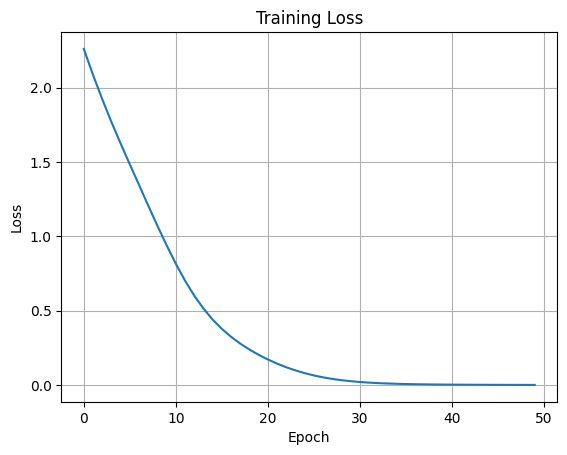

Input: i love => Prediction: ai (Target: ai)
Input: ai is => Prediction: amazing (Target: amazing)
Input: transformers learn => Prediction: context (Target: context)


In [ ]:
losses = []
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Predict on training data
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).argmax(dim=1)
    for i, pred_id in enumerate(predictions):
        print(f"Input: {sequences[i][0]} => Prediction: {inv_vocab[pred_id.item()]} (Target: {sequences[i][1]})")